In [1]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st

In [2]:
# Data - BHRC
# Reporter - clinician
# Hypothesis - 2a (depressed vs not depressed but with adhd/anxiety)

# Loading and prepping BHRC data

In [3]:
path_to_bhrcfile = '/data/MBDU/bhrc/data/Pine_129BHRC_2022_04_14.csv'
bhrcfile = pd.read_csv(path_to_bhrcfile, sep=',', header=0, low_memory=False)
print(bhrcfile.head(10))
print(bhrcfile.shape)

   ident redcap_event_name        age        agem      page1      page1m  \
0      1       wave0_arm_1   7.033539   84.402464        NaN         NaN   
1      1       wave1_arm_1  10.800821  129.609856  10.932238  131.186858   
2      1       wave2_arm_1  15.635866  187.630390  15.808350  189.700205   
3      2       wave0_arm_1   7.058179   84.698152        NaN         NaN   
4      2       wave1_arm_1  10.132786  121.593429  10.784394  129.412731   
5      2       wave2_arm_1  15.430527  185.166324  15.504449  186.053388   
6      3       wave0_arm_1   8.361396  100.336756   8.591376  103.096509   
7      3       wave1_arm_1  11.394935  136.739220  12.090349  145.084189   
8      3       wave2_arm_1  16.301164  195.613963  16.550308  198.603696   
9      4       wave0_arm_1  10.409309  124.911704        NaN         NaN   

       page2      page2m       nage       nagem  ...  np_cl_p_fl  \
0        NaN         NaN        NaN         NaN  ...         NaN   
1  10.932238  131.186858   

https://aseba.org/wp-content/uploads/DSM-Oriented-Guide-for-the-ASEBA.pdf <br>
DSM5 - summarize items  items 5, 14, 18, 24, 35, 52, 54, 76, 77, 91, 100, 102 and 103 <br>

### Table 1-3 a Items Comprising DSM-5-Oriented Scales for Ages 6-18
--> 5. Enjoys little (dom_s08_cbclp_w0w2 - cl5 - Few things give pleasure)<br>
--> 14. Cries (dom_s08_cbclp_w0w2 - cl14 - Cries a lot)<br>
--> 18. Harms self (cl18 - Hurts him/herself on purpose or tried to kill him/herself)<br>
--> 24. Doesn’t eat well (cl24 - Is hard to eat)<br>
--> 35. Worthless (cl35 - Feels worthless or inferior)<br>
--> 52. Guilty (cl52 - Feels very guilty)<br>
--> 54. Tired (cl54 - Feels too tired for no reason)<br>
--> 60. Apathetic - leave it because it's not in CBCL<br>
--> 76. Sleeps less (cl76 - Sleep less than most children)<br>
--> 77. Sleeps more (cl77 - Sleep more than most children during the day and / or at night)<br>
--> 91. Talks/thinks suicide (cl91 - Say you're going to kill yourself)<br>
--> 100. Sleep problems (cl100 - Have sleep problems)<br>
--> 102. Lacks energy  (cl102 - Is poorly active, slow in movement, or lacking energy)<br>
--> 103. Sad (cl103 - Is unhappy, sad or depressed)<br>


In [4]:
relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]

In [5]:
# Check if there are no "99"s

for column in relevant_depression_columns:
    print(bhrcfile[column].value_counts())

0.0     3686
1.0     1175
2.0      492
99.0      10
Name: cl5, dtype: int64
0.0    4241
1.0     774
2.0     349
Name: cl14, dtype: int64
0.0    5157
1.0     138
2.0      69
Name: cl18, dtype: int64
0.0     4310
1.0      696
2.0      357
99.0       1
Name: cl24, dtype: int64
0.0     4381
1.0      735
2.0      245
99.0       3
Name: cl35, dtype: int64
0.0     4835
1.0      417
2.0      108
99.0       4
Name: cl52, dtype: int64
0.0     3962
1.0      908
2.0      490
99.0       4
Name: cl54, dtype: int64
0.0     4643
1.0      452
2.0      268
99.0       1
Name: cl76, dtype: int64
0.0     3985
1.0      785
2.0      592
99.0       2
Name: cl77, dtype: int64
0.0     5077
1.0      199
2.0       84
99.0       3
Name: cl91, dtype: int64
0.0     4829
1.0      375
2.0      157
99.0       2
Name: cl100, dtype: int64
0.0     4671
1.0      532
2.0      155
99.0       5
Name: cl102, dtype: int64
0.0     4474
1.0      716
2.0      171
99.0       1
Name: cl103, dtype: int64


In [6]:
bhrcfile.head()

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,np_cl_p_fl,np_cl_int_fl,np_cl_ext_fl,np_cl_ddep_fl,np_cl_danx_fl,np_cl_dsoma_fl,np_cl_dadhd_fl,np_cl_dodd_fl,np_cl_dconduct_fl,schoolach_fl
0,1,wave0_arm_1,7.033539,84.402464,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.324395
1,1,wave1_arm_1,10.800821,129.609856,10.932238,131.186858,10.932238,131.186858,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.071568
2,1,wave2_arm_1,15.635866,187.630390,15.808350,189.700205,15.808350,189.700205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.224725
3,2,wave0_arm_1,7.058179,84.698152,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,wave1_arm_1,10.132786,121.593429,10.784394,129.412731,10.789870,129.478439,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015597


In [24]:
# check where nans are
checkdf = bhrcfile[(bhrcfile[relevant_depression_columns] >98).any(axis=1)]
print(checkdf.redcap_event_name.value_counts())
print(checkdf.p1dawbaage.value_counts())

wave2_arm_1    23
wave1_arm_1     4
Name: redcap_event_name, dtype: int64
16.950034    1
16.386037    1
17.911020    1
16.071184    1
16.605065    1
14.056126    1
17.757700    1
13.645448    1
17.620808    1
16.867899    1
16.191650    1
17.938398    1
15.329227    1
16.769336    1
16.038330    1
15.906913    1
14.822724    1
17.806982    1
17.546886    1
17.648186    1
13.409993    1
15.509925    1
17.908282    1
16.900753    1
17.138946    1
17.812457    1
17.010267    1
Name: p1dawbaage, dtype: int64


In [ ]:
# no missing data in our age group. Phew.

In [6]:
# relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]
bhrcfile['cbcl_dsm_depression'] = bhrcfile.cl5 + bhrcfile.cl14 + bhrcfile.cl18 + bhrcfile.cl24 + bhrcfile.cl35 + bhrcfile.cl52 + bhrcfile.cl54 + bhrcfile.cl76 + bhrcfile.cl77 + bhrcfile.cl91 + bhrcfile.cl100 + bhrcfile.cl102 + bhrcfile.cl103
bhrcfile['cbcl_dsm_depression'].value_counts()

0.0     1669
1.0      907
2.0      716
3.0      485
4.0      398
6.0      254
5.0      249
7.0      150
8.0      133
9.0      103
10.0      69
11.0      54
12.0      52
13.0      33
15.0      28
14.0      19
16.0      12
17.0       9
18.0       8
19.0       4
20.0       4
21.0       3
23.0       1
22.0       1
Name: cbcl_dsm_depression, dtype: int64

In [7]:
bhrcfile['depression_clinician'] = (bhrcfile.dcmadep == 2) | (bhrcfile.dcotdep == 2)
bhrcfile['healthy_clinician'] = (bhrcfile.dcany == 0)
bhrcfile['anxiety_clinician'] = (bhrcfile.dcsepa == 2) | \
                        (bhrcfile.dcspph == 2) | \
                        (bhrcfile.dcsoph == 2) | \
                        (bhrcfile.dcpanic == 2) |\
                        (bhrcfile.dcagor == 2) | \
                        (bhrcfile.dcgena == 2) | \
                        (bhrcfile.dcotanx == 2) 
bhrcfile['ADHD_clinician'] = (bhrcfile.dcanyhk == 2)
bhrcfile['depYES_anxietyadhdNO_clinician'] = (bhrcfile.depression_clinician == True) & ((bhrcfile.anxiety_clinician == False) & (bhrcfile.ADHD_clinician == False))
bhrcfile['depNO_anxietyadhdYES_clinician'] = (bhrcfile.depression_clinician == False) & ((bhrcfile.anxiety_clinician == True) | (bhrcfile.ADHD_clinician == True))

bhrcfile['depression_clinician_9to13'] = (bhrcfile.depression_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['healthy_clinician_9to13'] = (bhrcfile.healthy_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['depYES_anxietyadhdNO_clinician_9to13'] = (bhrcfile.depYES_anxietyadhdNO_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['depNO_anxietyadhdYES_clinician_9to13'] = (bhrcfile.depNO_anxietyadhdYES_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)

In [8]:
bhrcfile['all_9to13'] = (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['all_9to13'].value_counts()

False    5274
True     2259
Name: all_9to13, dtype: int64

example table:<br>
<br>
ident redcap_event_name        age        agem      page1      page1m  \
0      1       wave0_arm_1   7.033539   84.402464        NaN         NaN   
1      1       wave1_arm_1  10.800821  129.609856  10.932238  131.186858   
2      1       wave2_arm_1  15.635866  187.630390  15.808350  189.700205   
3      2       wave0_arm_1   7.058179   84.698152        NaN         NaN   
4      2       wave1_arm_1  10.132786  121.593429  10.784394  129.412731   
5      2       wave2_arm_1  15.430527  185.166324  15.504449  186.053388   
6      3       wave0_arm_1   8.361396  100.336756   8.591376  103.096509   
7      3       wave1_arm_1  11.394935  136.739220  12.090349  145.084189   
8      3       wave2_arm_1  16.301164  195.613963  16.550308  198.603696   
9      4       wave0_arm_1  10.409309  124.911704        NaN         NaN   

In [8]:
#removing all rows where p1dawbaage <9 or >13
bhrcfile = bhrcfile[bhrcfile.p1dawbaage >= 9]
bhrcfile = bhrcfile[bhrcfile.p1dawbaage <= 13]
print(bhrcfile.shape)
print(bhrcfile['p1dawbaage'].value_counts())

(2259, 2261)
10.475017    8
11.271732    7
11.761807    6
11.797399    6
11.164956    6
            ..
12.114990    1
11.455168    1
11.507187    1
12.533881    1
9.505818     1
Name: p1dawbaage, Length: 1128, dtype: int64


In [9]:
bhrcfile.head()

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,depression_clinician,healthy_clinician,anxiety_clinician,ADHD_clinician,depYES_anxietyadhdNO_clinician,depNO_anxietyadhdYES_clinician,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13
1,1,wave1_arm_1,10.800821,129.609856,10.932238,131.186858,10.932238,131.186858,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
4,2,wave1_arm_1,10.132786,121.593429,10.784394,129.412731,10.789870,129.478439,NaN,NaN,...,False,False,True,False,False,True,False,False,False,True
7,3,wave1_arm_1,11.394935,136.739220,12.090349,145.084189,12.090349,145.084189,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
9,4,wave0_arm_1,10.409309,124.911704,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
13,5,wave1_arm_1,10.809035,129.708419,11.438741,137.264887,11.438741,137.264887,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False


In [10]:
bhrcfile.ident.value_counts()

2512    2
1976    2
567     2
2017    2
549     2
       ..
869     1
868     1
867     1
866     1
1296    1
Name: ident, Length: 2083, dtype: int64

In [11]:
# sort by age and subject and then group by subject and use .first()

In [12]:
bhrcfile.redcap_event_name.value_counts()

wave0_arm_1    1551
wave1_arm_1     708
Name: redcap_event_name, dtype: int64

In [13]:
bhrcfile = bhrcfile.replace('wave0_arm_1', 0)
bhrcfile = bhrcfile.replace('wave1_arm_1', 1)
bhrcfile = bhrcfile.replace('wave2_arm_1', 2)
bhrcfile.redcap_event_name.value_counts()

0    1551
1     708
Name: redcap_event_name, dtype: int64

In [14]:
bhrcfile = bhrcfile.sort_values(['ident', 'p1dawbaage'])
bhrcfile = bhrcfile.groupby(by=['ident'])
bhrcfile[['ident', 'redcap_event_name', 'p1dawbaage']].head(10)

,ident,redcap_event_name,p1dawbaage
1,1,1,10.937714
4,2,1,10.800821
7,3,1,12.054757
9,4,0,10.475017
13,5,1,11.173169
...,...,...,...
7521,2509,0,9.505818
7522,2509,1,12.703628
7528,2511,1,12.002738
7530,2512,0,9.297741


In [15]:
bhrcfile.ident.value_counts()

ident  ident
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
               ..
2507   2507     1
2508   2508     1
2509   2509     2
2511   2511     1
2512   2512     2
Name: ident, Length: 2083, dtype: int64

In [16]:
bhrcfile = bhrcfile.first('1D')
bhrcfile[['redcap_event_name', 'p1dawbaage']].head()

,redcap_event_name,p1dawbaage
ident,,
1,1,10.937714
2,1,10.800821
3,1,12.054757
4,0,10.475017
5,1,11.173169


In [17]:
bhrcfile = bhrcfile.reset_index(level=0)
bhrcfile.ident.value_counts()

1       1
1706    1
1703    1
1701    1
1700    1
       ..
853     1
850     1
849     1
848     1
2512    1
Name: ident, Length: 2083, dtype: int64

In [9]:
# checking numbers of depressed etc
print("Depressed 9 to 13 - clinician")
print(bhrcfile['depression_clinician_9to13'].value_counts())
print("\nHealthy 9 to 13 - clinician")
print(bhrcfile['healthy_clinician_9to13'].value_counts())
print("\ndepYES_anxietyadhdNO_clinician - clinician")
print(bhrcfile['depYES_anxietyadhdNO_clinician_9to13'].value_counts())
print("\ndepNO_anxietyadhdYES_clinician - clinician")
print(bhrcfile['depNO_anxietyadhdYES_clinician_9to13'].value_counts())
print("\nall 9 to 13")
print(bhrcfile['all_9to13'].value_counts())


Depressed 9 to 13 - clinician
False    7442
True       91
Name: depression_clinician_9to13, dtype: int64

Healthy 9 to 13 - clinician
False    5851
True     1682
Name: healthy_clinician_9to13, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
False    7483
True       50
Name: depYES_anxietyadhdNO_clinician_9to13, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
False    7152
True      381
Name: depNO_anxietyadhdYES_clinician_9to13, dtype: int64

all 9 to 13
False    5274
True     2259
Name: all_9to13, dtype: int64


In [19]:
bhrcfile.shape

(2083, 2152)

In [20]:
mybhrcfile = bhrcfile[['ident', 'p1dawbaage', 'redcap_event_name', 'depression_clinician_9to13', 'healthy_clinician_9to13', 'depYES_anxietyadhdNO_clinician_9to13', 'depNO_anxietyadhdYES_clinician_9to13', 'cbcl_dsm_depression']]
print(mybhrcfile.shape)
print(mybhrcfile.head())

(2083, 8)
   ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
0      1   10.937714                  1                       False   
1      2   10.800821                  1                       False   
2      3   12.054757                  1                       False   
3      4   10.475017                  0                       False   
4      5   11.173169                  1                       False   

   healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
0                     True                                 False   
1                    False                                 False   
2                     True                                 False   
3                     True                                 False   
4                     True                                 False   

   depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  
0                                 False                  0.0  
1                           

In [21]:
mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)
mybhrcfile.head(10)

/tmp/ipykernel_10235/2129885117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


,ident,p1dawbaage,redcap_event_name,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13,cbcl_dsm_depression,gs_depression
0,1,10.937714,1,False,True,False,False,0.0,0
1,2,10.800821,1,False,False,False,True,5.0,0
2,3,12.054757,1,False,True,False,False,1.0,0
3,4,10.475017,0,False,True,False,False,1.0,0
4,5,11.173169,1,False,True,False,False,1.0,0
5,6,10.795346,0,True,False,True,False,13.0,1
6,7,9.229295,0,False,True,False,False,0.0,0
7,9,12.394251,0,False,True,False,False,0.0,0
8,10,12.265572,1,False,True,False,False,3.0,0
9,11,10.154689,0,False,True,False,False,0.0,0


# HYPOTHESIS DIFFERENCES BEGIN HERE

We prepare a dataset to work with, with a desired length and positive-negative caase ratio

## Split into negative and positive gs diagnoses

In [22]:
is_gs_pos =  mybhrcfile['gs_depression']==1
pos_gs_all = mybhrcfile[is_gs_pos]
print(pos_gs_all.shape)

(80, 9)


In [23]:
pos_gs_all.head()

,ident,p1dawbaage,redcap_event_name,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13,cbcl_dsm_depression,gs_depression
5,6,10.795346,0,True,False,True,False,13.0,1
13,15,12.416153,0,True,False,True,False,4.0,1
82,96,11.816564,0,True,False,False,False,20.0,1
94,108,10.746064,0,True,False,True,False,11.0,1
127,145,11.236140,0,True,False,True,False,11.0,1


In [24]:
is_gs_neg =  mybhrcfile['depNO_anxietyadhdYES_clinician_9to13']==True
neg_gs_all = mybhrcfile[is_gs_neg]
print(neg_gs_all.shape)

(360, 9)


## Randomly choose the neg_ksads subsample

In [25]:
num_pos = pos_gs_all.shape[0]
size_subsample = 360 # !
print(size_subsample)
neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
print(neg_gs_subsample.head())
neg_gs_subsample.shape

360
     ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
595    739   11.934292                  0                       False   
891   1121   12.572211                  1                       False   
628    779   10.759754                  1                       False   
478    589   10.861054                  0                       False   
534    663   12.090349                  0                       False   

     healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
595                    False                                 False   
891                    False                                 False   
628                    False                                 False   
478                    False                                 False   
534                    False                                 False   

     depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  gs_depression  
595                                  True               

(360, 9)

## Mix all positive cases and the subsample of negative cases. Then shuffle. 

In [26]:
frames = [pos_gs_all, neg_gs_subsample]
my_subsample = pd.concat(frames)
print(my_subsample.head())
print(my_subsample.shape)
my_subsample = my_subsample.sample(frac = 1)
print(my_subsample.head())
print(my_subsample.shape)

     ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
5        6   10.795346                  0                        True   
13      15   12.416153                  0                        True   
82      96   11.816564                  0                        True   
94     108   10.746064                  0                        True   
127    145   11.236140                  0                        True   

     healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
5                      False                                  True   
13                     False                                  True   
82                     False                                 False   
94                     False                                  True   
127                    False                                  True   

     depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  gs_depression  
5                                   False                 13

In [27]:
my_subsample.isnull().sum()

ident                                   0
p1dawbaage                              0
redcap_event_name                       0
depression_clinician_9to13              0
healthy_clinician_9to13                 0
depYES_anxietyadhdNO_clinician_9to13    0
depNO_anxietyadhdYES_clinician_9to13    0
cbcl_dsm_depression                     0
gs_depression                           0
dtype: int64

# AUCROC
## Heavily using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [28]:
y_true_df = my_subsample['gs_depression']
y_cbcl_df = my_subsample['cbcl_dsm_depression']

y_true = my_subsample['gs_depression'].tolist() # called y_test in the example
y_cbcl = my_subsample['cbcl_dsm_depression'].tolist() # called y_score in the example

In [29]:
sample_auc_score = roc_auc_score(y_true, y_cbcl)
sample_auc_score
# We don't report this number in the paper.
# Instead, we run bootstrapping and report the bootstrapped AUCROC, with confidence intervals

0.7826388888888889

# plotting

In [31]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true_df, y_cbcl_df)
roc_auc = auc(fpr, tpr)
roc_auc

0.7826388888888889

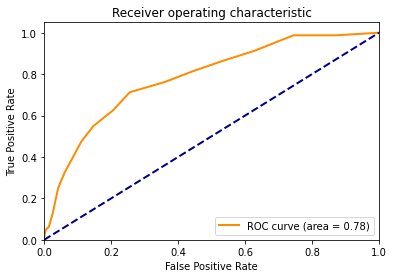

In [32]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# SAving

In [25]:
# we save these data to plot all plots from the same dataset (here BHRC) in one figure, for the paper

In [33]:
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2a_y_true_df.npy', 'wb') as f:
    np.save(f, y_true_df)
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2a_y_cbcl_df.npy', 'wb') as f:
    np.save(f, y_cbcl_df)

In [34]:
# Checking
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2a_y_true_df.npy', 'rb') as f:
    my_true_df = np.load(f)
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2a_y_cbcl_df.npy', 'rb') as f:
    my_cbcl_df = np.load(f)

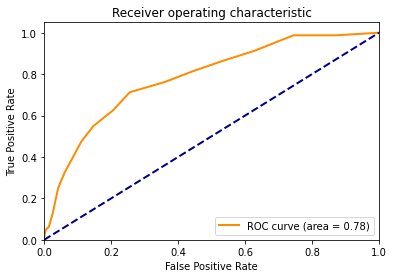

In [35]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Bootstrapping

In [36]:
rng = np.random.default_rng()
boot_ind = rng.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
boot_ind

array([249, 244, 159, 402,  67, 199, 359, 390, 127, 287,  71, 395, 144,
        53, 421, 222,  48, 291, 161, 383,  75, 339, 401,  15,  10, 336,
       423, 126,  47, 279, 406, 231, 330,  37,  14,  22, 405, 410, 110,
        94,  23, 188, 229, 352, 433,  40, 324, 237, 403, 433, 337, 344,
        87, 178, 284, 357, 438, 251, 145,  69,  93, 144, 256, 360, 387,
       187,  62, 155, 324, 249,  21, 427, 408,  56,  24, 332, 212, 323,
       390,  91, 140,  71, 247, 402, 439, 381, 160, 415, 106, 156, 292,
       255, 190,  35, 326,  43, 159, 234, 298,   0, 200,  35, 151,  22,
       211,  73, 262, 394, 138, 352, 328, 419, 346, 279, 403, 266,  46,
        32, 121,  62, 353, 325, 350, 397,  50,  68, 255,  58, 237, 279,
       227, 346, 388, 303, 198, 235, 200,  73, 140, 416, 148, 251,  73,
        41, 439,  42, 435, 304, 261,  36,  64, 344,  27, 210,  75, 378,
       260,  59, 105, 300, 388, 104,  89, 294, 228, 315, 116, 166, 380,
       371, 294, 431, 187, 260, 214, 397, 374, 356, 433,  90, 20

In [37]:
print(type(y_true_df))
y_true_df = y_true_df.to_frame()
y_cbcl_df = y_cbcl_df.to_frame()
print(type(y_true_df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [38]:
y_true_df.head()

,gs_depression
1426,0
735,0
1543,0
1492,0
37,0


In [39]:
boot_truth = y_true_df.iloc[boot_ind]
boot_score = y_cbcl_df.iloc[boot_ind]
print(y_cbcl_df.head(5))
print(boot_score.head(5))

      cbcl_dsm_depression
1426                  3.0
735                  13.0
1543                  5.0
1492                  5.0
37                    0.0
      cbcl_dsm_depression
783                   7.0
1824                  5.0
605                   8.0
107                   4.0
231                   8.0


In [40]:
def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

In [41]:
target_auc = 0.8 # because we defined it this way. Change for Hyp 2b.

boots = gen_auc_boots(y_cbcl_df, y_true_df, nboots=1000, rng=rng)
boots = np.hstack([boots, np.array([sample_auc_score])])
p = (boots >= target_auc).mean()

In [42]:
boots

array([0.78724198, 0.754375  , 0.77219022, ..., 0.81602796, 0.81243701,
       0.78263889])

In [43]:
min(boots)

0.6968

In [44]:
p

0.2887112887112887

In [45]:
target_auc

0.8

# RESULTS

In [46]:
p_onesided = (boots >= target_auc).mean()
p_onesided

0.2887112887112887

In [47]:
p_twosided1 = (boots > target_auc).mean()
p_twosided2 = (boots < target_auc).mean()
p_twosided = min(p_twosided1, p_twosided2)*2
p_twosided

0.5774225774225774

In [ ]:
print(np.quantile(boots, .025))
print(np.quantile(boots, .975))
boots_mean_AUCROC = np.mean(boots)
print(boots_mean_AUCROC, '(', np.quantile(boots, .025), np.quantile(boots, .975), ')')

# Confusion matrix

In [52]:
conf_fpr, conf_tpr, conf_thresh = roc_curve(y_true, y_cbcl)
conf_thresh

array([22., 21., 20., 18., 16., 15., 13., 12., 11., 10.,  9.,  8.,  7.,
        6.,  5.,  4.,  3.,  2.,  1.,  0.])

In [53]:
roc_auc = auc(conf_fpr, conf_tpr)
roc_auc

0.7826388888888889

In [54]:
print(y_cbcl[:50])
print(min(y_cbcl))
print(max(y_cbcl))

[3.0, 13.0, 5.0, 5.0, 0.0, 6.0, 1.0, 6.0, 0.0, 18.0, 1.0, 0.0, 2.0, 4.0, 10.0, 7.0, 0.0, 3.0, 2.0, 4.0, 3.0, 2.0, 6.0, 5.0, 1.0, 6.0, 1.0, 1.0, 5.0, 4.0, 8.0, 2.0, 10.0, 16.0, 10.0, 5.0, 0.0, 5.0, 7.0, 4.0, 13.0, 7.0, 3.0, 2.0, 4.0, 5.0, 21.0, 7.0, 20.0, 5.0]
0.0
21.0


In [55]:
def predict_y(cbcl, threshold):
    y_score = []
    for item in y_cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

In [56]:
# Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn

# and also euclidian distance
# --> tpr - y axis 
# --> fpr - x axis 
# We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 

## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 

# I will create the df from a list of lists

# first initiate the lists

all_roc_auc = []
all_fpr = []
all_tpr = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
all_thresholds = []
all_euclidian = []

# Point to calculate the Euclidian distance with - (0, 1)
optimal_performance = np.array((0, 1))

# now iterate through thesholds, calculate the values of interest, update the lists

for threshold in range (0,50): #51,90
    # predict diagnoses with the given threshold
    y_score = predict_y(y_cbcl, threshold)
    # calculate fp, fn, tp, tn, aucroc
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    # calculate euclidian
    fpr_tpr_datapoint = np.array((fpr, tpr))
    sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
    euclidian = np.sqrt(sum_sq)
    
    # update all lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)
    all_tp.append(tp)
    all_thresholds.append(threshold)
    all_euclidian.append(euclidian)


# make a dataframe out of lists

conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)),
               columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])

conf_matrices_data

,threshold,Euclidian,FPR,TPR,TP,TN,FP,FN
0,0,1.000000,1.000000,1.0000,80,0,360,0
1,1,0.872312,0.872222,0.9875,79,46,314,1
2,2,0.744549,0.744444,0.9875,79,92,268,1
3,3,0.633846,0.627778,0.9125,73,134,226,7
4,4,0.548083,0.530556,0.8625,69,169,191,11
5,5,0.479818,0.441667,0.8125,65,201,159,15
6,6,0.432212,0.361111,0.7625,61,230,130,19
7,7,0.384662,0.255556,0.7125,57,268,92,23
8,8,0.427642,0.205556,0.6250,50,286,74,30
9,9,0.473471,0.147222,0.5500,44,307,53,36


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


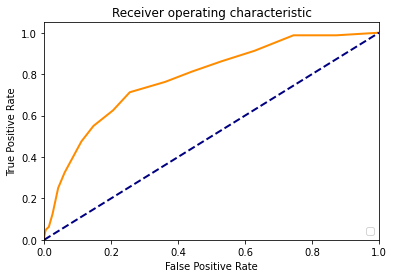

In [57]:
# Just to visualize

plt.figure()
lw = 2 # linewidt
plt.plot(
    all_fpr,
    all_tpr,
    color="darkorange",
    lw=lw,
    #label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [58]:
# Find the best fpr/tpr pair

# What is the min euclidian distance in the dataframe?
conf_matrices_data[['Euclidian']].idxmin()

Euclidian    7
dtype: int64

In [59]:
conf_matrices_data.loc[7]

threshold      7.000000
Euclidian      0.384662
FPR            0.255556
TPR            0.712500
TP            57.000000
TN           268.000000
FP            92.000000
FN            23.000000
Name: 7, dtype: float64